# Reverse Process

## Imports

In [1]:
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
from cv2 import cvtColor, COLOR_BGR2RGB, COLOR_LAB2RGB, COLOR_LAB2BGR
import sys
from einops import rearrange

sys.path.append('../')
#from util import LABtoRGB
from scripts import customUNet as unet
from scripts import forward_process as fp, reverse_process as rp, train, util

## Load image from dataset

In [2]:
ab1 = np.load("../data/image-colorization/ab/ab/ab1.npy")
ab2 = np.load("../data/image-colorization/ab/ab/ab2.npy")
ab3 = np.load("../data/image-colorization/ab/ab/ab3.npy")
l = np.load("../data/image-colorization/l/gray_scale.npy")
# Concatenate the numpy files
ab = np.concatenate((ab1,ab2,ab3),axis=0)

In [3]:
lab = np.zeros((1,224,224,3))
img_index= 5000 # not used during training
lab[:,:,:,0] = l[img_index,:]
lab[:,:,:,1:] = ab[img_index,:]    

lab = lab[0].astype("uint8")
lab.shape

(224, 224, 3)

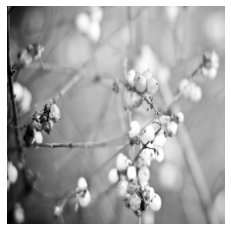

In [4]:
plt.axis('off')
plt.imshow(lab[:,:,0], cmap='gray')

In [5]:
# Load the color LAB image
size=64
img = cv2.normalize(lab, None, alpha = -1, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
img = cv2.resize(img, dsize=(size, size), interpolation=cv2.INTER_CUBIC)

img = torch.tensor(np.array(img))
# Reshape so the tensor has the right shape for training
img = rearrange(img,"h w c-> 1 c h w")
img.shape

torch.Size([1, 3, 64, 64])

In [6]:
# Take the L part of the LAB image to have grayscale
gray = img[:,0,:,:]
gray = rearrange(gray,"b w h-> b w h 1")
gray = gray.expand(gray.shape[0],gray.shape[1],gray.shape[2],3)
gray = rearrange(gray,"b w h c-> b c w h")
gray.shape

torch.Size([1, 3, 64, 64])

## Load model

In [7]:
T = 300
diffTerms = util.ConstantDiffusionTerms(T, fp.linear_beta_schedule)
model = unet.CustomConditionalUNet()
model.load_state_dict(torch.load("../models/modelv1.pth"))
device = util.set_device()
model.to(device);

## Sample

In [13]:
noisy_images = rp.p_sample_loop(model,gray.shape,device,T,gray,diffTerms)

Saving image at timestep 270
Saving image at timestep 240
Saving image at timestep 210
Saving image at timestep 180
Saving image at timestep 150
Saving image at timestep 120
Saving image at timestep 90
Saving image at timestep 60
Saving image at timestep 30
Saving image at timestep 0


In [14]:
len(noisy_images)

10

In [16]:
results = []
for img in noisy_images:
    img = rearrange(img,"b c w h-> b w h c")[0]
    norm = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    norm = norm.astype("uint8")
    img_rgb = cv2.cvtColor(norm,cv2.COLOR_LAB2RGB)
    results.append(img_rgb)

X_0 is the last element displayed


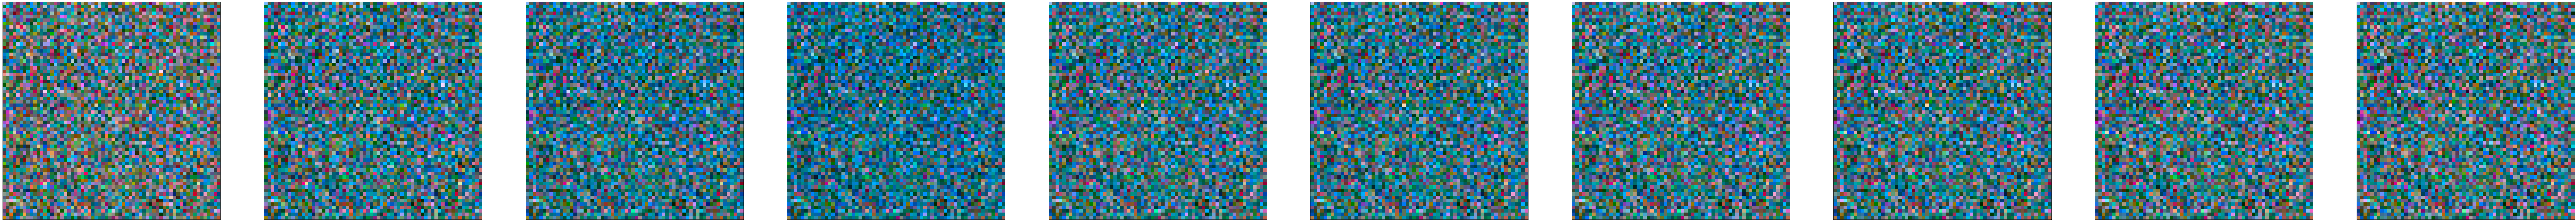

In [17]:
if not isinstance(results[0], list):
    results = [results]

num_rows = len(results)
num_cols = len(results[0])
fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)

for row_idx, row in enumerate(results):
    row = row
    for col_idx, img in enumerate(row):
        ax = axs[row_idx, col_idx]
        ax.imshow(np.asarray(img))
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
print("X_0 is the last element displayed")

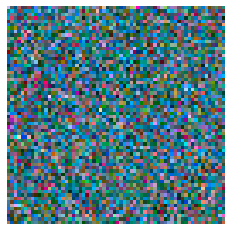

In [18]:
plt.axis('off')
plt.imshow(np.asarray(results[0][-1]))